# The impact of using a GPU versus not

Here are some quick benchmarks of how much a GPU helps with speed.  The test is simple: I'll generate some large, random matrices, and multiple them on the CPU versus GPU, and we'll compare speeds.  I'm _not_ going to include the time it takes to move the tensor to the GPU; with a neural network, the internal tensors typically live their whole life on one device or the other, so the overhead of moving/copying them is minimal compared to the overhead of doing computations.  (the overhead of moving your _data_ around, though, is non-trivial, and can sometimes cause small networks to be _slower_ on a GPU).

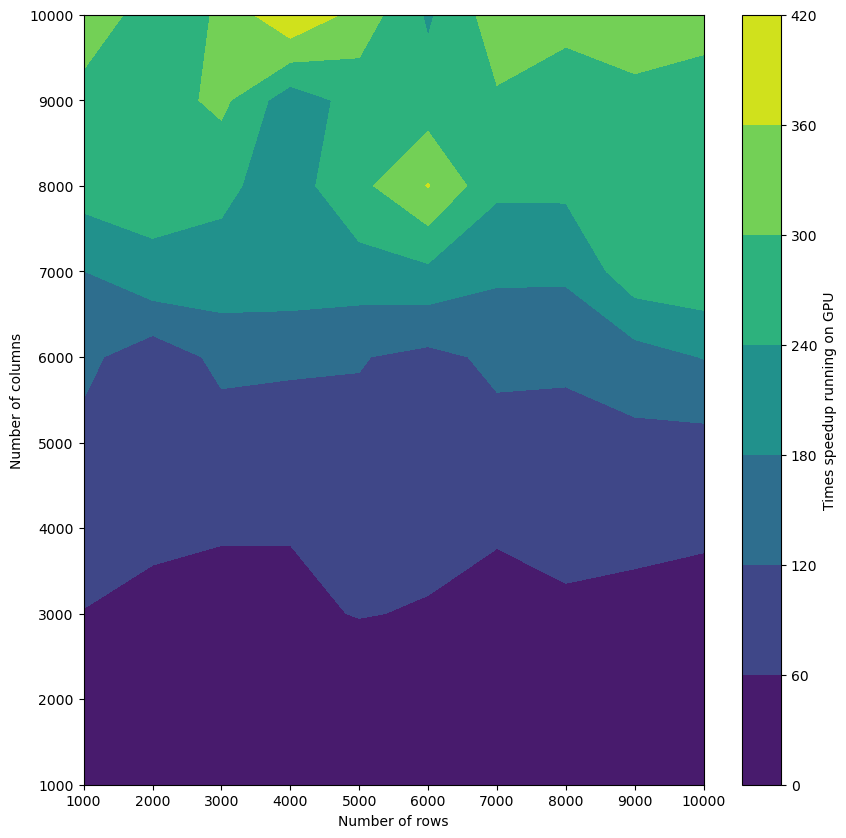

In [50]:
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

cpu_times = []
gpu_times = []
xs = list(range(1000, 10_001, 1000))
ys = list(range(1000, 10_001, 1000))
ratios = np.zeros((len(xs), len(ys)))

global_start = perf_counter()
for i in range(len(xs)):
    for j in range(len(ys)):
        # hacking together a little progress message
        start_time = int(perf_counter() - global_start)
        print(" "*50, end="\r", flush=True)
        print(f"[{start_time}s] {xs[i]}x{ys[j]} matrix", end="\r", flush=True)
        
        x = torch.rand(xs[i], ys[i], dtype=torch.float32)

        # matrix multiplication on CPU
        cpu_time = perf_counter()
        _ = torch.matmul(x, x.T)
        cpu_time = perf_counter() - cpu_time
        cpu_times.append(cpu_time)

        # matrix multiplication on GPU
        x = x.cuda()
        gpu_time = perf_counter()
        _ = torch.matmul(x, x.T)
        gpu_time = perf_counter() - gpu_time
        gpu_times.append(gpu_time)

        ratio = cpu_time / gpu_time
        ratios[i, j] = ratio

        # deleting these now-on-the-GPU variables should tell PyTorch/
        # CUDA to clean up the used memory.
        del x, _
    
    
fig, ax = plt.subplots(figsize=(10,10))
contour = ax.contourf(xs, ys, ratios)
fig.colorbar(contour, label="Times speedup running on GPU")
ax.set_xlabel("Number of rows")
ax.set_ylabel("Number of columns")
plt.show()